# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn, Iterable, Tuple
import tqdm

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [3]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        raise NotImplementedError()
        
    def update(self, alpha):
        pass

In [4]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        self._w = np.random.randn(in_features, out_features)
        self._b = np.random.randn(out_features)

        self._in = None
        self._grad_w = None
        self._grad_b = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        self._in = x
        return x @ self._w + self._b
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self._grad_w = self._in.T @ d
        self._grad_b = np.sum(d, axis=0)
        return d @ self._w.T
        
    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self._w -= alpha * self._grad_w
        self._b -= alpha * self._grad_b

In [5]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        self._in = None
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        self._in = x
        return np.maximum(0, x)
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        return d * (self._in >= 0)

In [6]:
def softmax(x: np.ndarray):
    x -= np.max(x, axis=-1, keepdims=True)
    exp = np.exp(x)
    return exp / np.sum(exp, axis=-1, keepdims=True)

        
class SoftmaxCrossEntropy:
    """
    Слой, соответствующий функции активации Softmax с последующим CrossEntropy
    """
    def __init__(self):
        self._labels = None
        self._probs = None

    def forward(self, x: np.ndarray, labels: np.ndarray) -> np.ndarray:
        """
        Возвращает L = CrossEntropy(Softmax(x)).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.

        Return
        ------
        y : np.ndarray
            Выход после слоя (одно число).

        """
        self._labels = labels

        self._probs = softmax(x)

        selected_probs = self._probs[range(self._probs.shape[0]), labels]
        selected_log_probs = np.log(selected_probs + np.finfo(x.dtype).eps)
        log_loss = -np.mean(selected_log_probs)

        return log_loss

    def backward(self) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Нисходящий градиент
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        grad = self._probs
        grad[range(grad.shape[0]), self._labels] -= 1
        return grad / self._probs.shape[0]

### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [7]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        self._modules = copy.copy(modules)
        self._epochs = epochs
        self._alpha = alpha

        self._softmax_loss = SoftmaxCrossEntropy()
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        for epoch_num in tqdm.trange(self._epochs):
            losses = []
            for x_batch, y_batch in MLPClassifier._batchify(X, y, batch_size):
                # forward pass
                out = x_batch
                for module in self._modules:
                    out = module.forward(out)
                # loss calc
                loss = self._softmax_loss.forward(out, y_batch)
                losses.append(loss)
                # backward pass and params update
                grad = self._softmax_loss.backward()
                for module in reversed(self._modules):
                    grad = module.backward(grad)
                    module.update(self._alpha)
            print(f"Last loss: {loss}, Avg loss: {sum(losses) / len(losses)}")

        
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        out = X
        for module in self._modules:
            out = module.forward(out)
        return softmax(out)
        
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

    @staticmethod
    def _batchify(x: np.ndarray, y: np.ndarray, batch_size: int) -> Iterable[Tuple[np.ndarray, np.ndarray]]:
        mask = np.random.permutation(x.shape[0])
        x_shuffled, y_shuffled = x[mask], y[mask]
        xs = np.split(x_shuffled, range(batch_size, x.shape[0], batch_size))
        ys = np.split(y_shuffled, range(batch_size, y.shape[0], batch_size))
        return ((x_batch, y_batch) for x_batch, y_batch in zip(xs, ys))

In [8]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = np.array([(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X])
p.fit(X, y)

100%|██████████| 40/40 [00:00<00:00, 924.56it/s]

Last loss: 8.806795493024202, Avg loss: 14.047906304429699
Last loss: 4.936174245524963, Avg loss: 5.950837271261423
Last loss: 3.470360225816174, Avg loss: 3.372486682391254
Last loss: 2.2536578682328536, Avg loss: 2.881895991707745
Last loss: 1.913650276049026, Avg loss: 1.9585653007600783
Last loss: 1.0860868398015595, Avg loss: 1.693923242689793
Last loss: 0.0005451575455588356, Avg loss: 1.593419768230646
Last loss: 2.8436921414769167, Avg loss: 1.9938482574563952
Last loss: 2.388721699769063, Avg loss: 1.6548170182360913
Last loss: 2.0185822050847033, Avg loss: 1.3459696171533428
Last loss: 0.6184383710492584, Avg loss: 0.798524623221702
Last loss: 7.705675541716768, Avg loss: 5.491117611607668
Last loss: 0.48775504671559783, Avg loss: 1.9531764523119064
Last loss: 1.7552380514980277, Avg loss: 1.0014425923223758
Last loss: 0.27426785798093667, Avg loss: 0.6861283120947554
Last loss: 1.3006898770902184, Avg loss: 1.1114094900268698
Last loss: 0.0014390303529037212, Avg loss: 0.54

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [9]:
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 16),
        ReLU(),
        Linear(16, 16),
        ReLU(),
        Linear(16, 2)
    ])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.37027542203639874, Avg loss: 3.7648303242522134
Last loss: 0.49029238300906064, Avg loss: 0.49677224354879546
Last loss: 0.3561586895083439, Avg loss: 0.3649178437191886
Last loss: 0.3163552997991038, Avg loss: 0.34664847088680434
Last loss: 0.3558051387800101, Avg loss: 0.335980726204351
Last loss: 0.7301147472883238, Avg loss: 0.33148810240969834
Last loss: 0.5813229149984508, Avg loss: 0.34300390159566807
Last loss: 0.18295475951638673, Avg loss: 0.29994207004742174
Last loss: 0.20931987890716494, Avg loss: 0.29318179052784943
Last loss: 0.3395769531366661, Avg loss: 0.2924102924888096
Last loss: 0.09009776920369222, Avg loss: 0.27953842622872993
Last loss: 0.349837475474524, Avg loss: 0.2798470899386874
Last loss: 0.2884120281704303, Avg loss: 0.2643031583839549
Last loss: 0.377932425448989, Avg loss: 0.27787508771714947
Last loss: 0.2966429221410205, Avg loss: 0.2654398637073856
Last loss: 0.18659283961500817, Avg loss: 0.26222814518025606
Last loss: 0.283616657367843

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.05779569715777644, Avg loss: 0.08651108093443813
Last loss: 0.08118612974834187, Avg loss: 0.08468812877887945
Last loss: 0.13877687047471765, Avg loss: 0.0851763998114797
Last loss: 0.08417148693948245, Avg loss: 0.08031209561906194
Last loss: 0.018556938474398734, Avg loss: 0.07591232255413374
Last loss: 0.18569894724680913, Avg loss: 0.08047773352347942
Last loss: 0.1317514621571452, Avg loss: 0.07728159026918796
Last loss: 0.05608841416965431, Avg loss: 0.07224608137463119
Last loss: 0.07020903470361035, Avg loss: 0.0712152069048632
Last loss: 0.09465216412764929, Avg loss: 0.07068703603521012
Last loss: 0.049322129782594565, Avg loss: 0.06722852557637247
Last loss: 0.06719576753327702, Avg loss: 0.0658202128686324
Last loss: 0.03374379435136335, Avg loss: 0.06297039178142837
Last loss: 0.015330462556369039, Avg loss: 0.060779681270069164
Last loss: 0.04677828370979772, Avg loss: 0.060096571334207954
Last loss: 3.1527385731986772, Avg loss: 7.565579514523833
Last loss:

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.2390746760072089, Avg loss: 0.21430318388509143
Last loss: 0.24777275906632784, Avg loss: 0.21391428898796666
Last loss: 0.19637119292518293, Avg loss: 0.20856553890108856
Last loss: 0.19201088004859512, Avg loss: 0.2061696949027249
Last loss: 0.14020150719868688, Avg loss: 0.19731205953330153
Last loss: 0.11370267551759727, Avg loss: 0.1913280015135751
Last loss: 0.07125246366862995, Avg loss: 0.19455066203167343
Last loss: 0.20194483324361664, Avg loss: 0.1881621389435487
Last loss: 0.16869443475396093, Avg loss: 0.18635614758118202
Last loss: 0.33973988664932553, Avg loss: 0.19010959685725407
Last loss: 0.22240205751668768, Avg loss: 0.18279041145814054
Last loss: 0.2622436445638248, Avg loss: 0.18191829302557222
Last loss: 0.24335118516310333, Avg loss: 0.18020973421905942
Last loss: 0.11951961684759306, Avg loss: 0.17203118638961196
Last loss: 0.10638160734314524, Avg loss: 0.17133646167651215
Last loss: 0.0905963123588241, Avg loss: 0.17078583045833684
Last loss: 0.1

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.1108453274141589, Avg loss: 0.11896352640039608
Last loss: 0.17879305986335836, Avg loss: 0.11584874472806547
Last loss: 0.06615517354658412, Avg loss: 0.10984423325132053
Last loss: 0.07886130461261961, Avg loss: 0.10563317916353926
Last loss: 0.1594868060767057, Avg loss: 0.10439260996001999
Last loss: 0.09151788600639707, Avg loss: 0.10046509939001678
Last loss: 0.07188101205301069, Avg loss: 0.09429592569436249
Last loss: 0.11346483774035271, Avg loss: 0.09356403770548158
Last loss: 0.05854407537730296, Avg loss: 0.08827495420126656
Last loss: 0.07089170460743896, Avg loss: 0.0859264300192055
Last loss: 2.460941370249473, Avg loss: 3.142376416473159
Last loss: 1.2595508340217558, Avg loss: 0.8591140370646806
Last loss: 0.5387621326334431, Avg loss: 0.5547661516577223
Last loss: 0.391622424293939, Avg loss: 0.38455468176145813
Last loss: 0.2536706075695072, Avg loss: 0.29378104049613574
Last loss: 0.12420948394190796, Avg loss: 0.23842884437208248
Last loss: 0.179713768

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.08524616664081547, Avg loss: 0.15789191850737627
Last loss: 0.19196160392115594, Avg loss: 0.1516738499508486
Last loss: 0.07773100585556716, Avg loss: 0.14303766134275725
Last loss: 0.2249977285530011, Avg loss: 0.14160290562359626
Last loss: 0.027289543894022134, Avg loss: 0.12623930158199279
Last loss: 0.2057918694154524, Avg loss: 0.12738194741893394
Last loss: 0.0996699622629657, Avg loss: 0.12470546913630728
Last loss: 0.027287938670909315, Avg loss: 0.12125209198747526
Last loss: 0.05728304840373893, Avg loss: 0.11138119899384037
Last loss: 0.1552888460136719, Avg loss: 0.11155439964030107
Last loss: 0.01984394846272985, Avg loss: 0.10050203494147941
Last loss: 0.12356267468095662, Avg loss: 0.10031463512176843
Last loss: 0.06077805260284713, Avg loss: 0.10086293064901916
Last loss: 0.1086811299602317, Avg loss: 0.09445455602492094
Last loss: 0.059666659524106894, Avg loss: 0.09251008732690964
Last loss: 0.10079625390029491, Avg loss: 0.08836795419563746
Last loss: 

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 1.104025683792047, Avg loss: 0.8764350267520766
Last loss: 0.3105648131771648, Avg loss: 0.3946040275420375
Last loss: 0.11464557353643087, Avg loss: 0.2567991677929791
Last loss: 0.5397280758910461, Avg loss: 0.2073696720544987
Last loss: 0.06323120344289443, Avg loss: 0.15087753392842157
Last loss: 0.16659243962147413, Avg loss: 0.1339084487114045
Last loss: 0.26974499384104245, Avg loss: 0.1212297053958269
Last loss: 0.05028898982156518, Avg loss: 0.09990892266786947
Last loss: 0.1273451354898575, Avg loss: 0.09153831331460648
Last loss: 0.04655641250495584, Avg loss: 0.08052858623629036
Last loss: 0.12091230468287265, Avg loss: 0.0767283665671906
Last loss: 0.055319696462595894, Avg loss: 0.06753646872357556
Last loss: 0.030626612760166313, Avg loss: 0.06217515163914559
Last loss: 0.07200831547368113, Avg loss: 0.05899611380814757
Last loss: 0.030665495592032428, Avg loss: 0.054024404840549586
Last loss: 0.00785349869994613, Avg loss: 0.04961600954744415
Last loss: 0.070

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.07479252405269873, Avg loss: 0.1340408735678678
Last loss: 0.16444275566497105, Avg loss: 0.14212388364100143
Last loss: 0.0988366255324972, Avg loss: 0.13051610642519026
Last loss: 0.03159152280861245, Avg loss: 0.12556889575731464
Last loss: 0.04814056721317142, Avg loss: 0.1302622938594245
Last loss: 0.1814378753661734, Avg loss: 0.12427410295978565
Last loss: 0.12228579157316846, Avg loss: 0.12533405701068517
Last loss: 0.20194655329971156, Avg loss: 0.12295771469963035
Last loss: 0.0677734753638577, Avg loss: 0.11696269717886719
Last loss: 0.05685828844531903, Avg loss: 0.11654114291727921
Last loss: 0.1284566097963973, Avg loss: 0.11597720345165893
Last loss: 0.05518061709723503, Avg loss: 0.11494374995731291
Last loss: 0.34342510735243004, Avg loss: 1.106680033070993
Last loss: 0.9340478720658445, Avg loss: 0.5722421824762605
Last loss: 0.3096146997054565, Avg loss: 0.5188192329959147
Last loss: 0.5351164181742494, Avg loss: 0.46305396863455645
Last loss: 0.38648251

100%|██████████| 40/40 [00:00<00:00, 348.65it/s]

Last loss: 0.305339696682828, Avg loss: 0.12113894413851453
Last loss: 0.07605481873664392, Avg loss: 0.11268033357618079
Last loss: 0.13380818019852006, Avg loss: 0.10687345740483457
Last loss: 0.043314407236984404, Avg loss: 0.09973361248212588
Last loss: 0.17323174640093086, Avg loss: 0.10082334373802065
Last loss: 0.04109666910070653, Avg loss: 0.0923179168651591
Last loss: 0.009494808137355683, Avg loss: 0.08829712525944841
Last loss: 0.037363724898444084, Avg loss: 0.08654480612437612
Last loss: 0.03714546983663672, Avg loss: 0.0834168782734536
Last loss: 0.04288860235476491, Avg loss: 0.08151660157755115
Last loss: 0.07961115412441727, Avg loss: 0.0804515828609054
Last loss: 0.050832385136091264, Avg loss: 0.07766438065264028
Last loss: 0.050137007387792684, Avg loss: 0.07509079386300378
Last loss: 0.09055041238829592, Avg loss: 0.07544297586838564
Last loss: 0.09994594740541722, Avg loss: 0.07352484800164488
Last loss: 0.01578581197494276, Avg loss: 0.06897747342916544
Last los


  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 4.190144457066046, Avg loss: 7.449533810870518
Last loss: 1.6169900061821756, Avg loss: 2.420560266405791
Last loss: 0.8744299466837422, Avg loss: 1.1631851376991744
Last loss: 0.47943219913359464, Avg loss: 0.6976505415747531
Last loss: 0.5395855711689739, Avg loss: 0.5391208240526335
Last loss: 0.5466559677994651, Avg loss: 0.4683673378669696
Last loss: 0.34501476323534636, Avg loss: 0.41586870873217846
Last loss: 0.45172186599207187, Avg loss: 0.38744756925367313
Last loss: 0.6089876437850216, Avg loss: 0.37057045858424825
Last loss: 0.10024738087974092, Avg loss: 0.3401517134208599
Last loss: 0.3911563109542322, Avg loss: 0.33041984352515275
Last loss: 0.3867843367262727, Avg loss: 0.32008288490598874
Last loss: 0.4148124330610221, Avg loss: 0.308304829653833
Last loss: 0.11203147294647801, Avg loss: 0.2888985249632379
Last loss: 0.4472727066541606, Avg loss: 0.2935374621851229
Last loss: 0.1205694222701349, Avg loss: 0.27556646839496823
Last loss: 0.3115024166189462, Av

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.0562272962947648, Avg loss: 0.0978906691439641
Last loss: 0.109151136812011, Avg loss: 0.09828440124930368
Last loss: 0.08606356341075302, Avg loss: 0.09577921136464385
Last loss: 0.08335123661478805, Avg loss: 0.09496963307080025
Last loss: 0.022740265191271543, Avg loss: 0.0900601765478983
Last loss: 0.1111328296077321, Avg loss: 0.09245429978072747
Last loss: 0.10347417001916226, Avg loss: 0.0902477564211221
Last loss: 0.2259321115026845, Avg loss: 0.09361645966391206
Last loss: 0.17418600677631496, Avg loss: 0.09148828172118752
Last loss: 0.04695605117322092, Avg loss: 0.0846751739436262
Last loss: 0.16419683247004735, Avg loss: 0.08861130235835973
Last loss: 0.05567607860323298, Avg loss: 0.08239391726860021
Last loss: 0.16705332344052737, Avg loss: 0.08672267226315994
Last loss: 0.4173215234415235, Avg loss: 4.877595503911201
Last loss: 0.2390556306972667, Avg loss: 0.34714663326021566
Last loss: 0.3057399799255517, Avg loss: 0.2811662768021394
Last loss: 0.300460546

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.25196210877094666, Avg loss: 0.25240926570413047
Last loss: 0.35763940717879006, Avg loss: 0.24812090900845696
Last loss: 0.25238886804148636, Avg loss: 0.23591479965363205
Last loss: 0.18206120135908493, Avg loss: 0.2274638323873958
Last loss: 0.18019485661822704, Avg loss: 0.2190182516317703
Last loss: 0.33184764104881326, Avg loss: 0.2206661104822816
Last loss: 0.19216199885467267, Avg loss: 0.210257759618754
Last loss: 0.33204060178499734, Avg loss: 0.21050981843738104
Last loss: 0.19109880572800791, Avg loss: 0.20069479557577996
Last loss: 0.25311235289164535, Avg loss: 0.2003021491054907
Last loss: 0.21804944397292483, Avg loss: 0.1950307858009473
Last loss: 0.260375965798923, Avg loss: 0.193404022112496
Last loss: 0.1040479532898041, Avg loss: 0.18495381400822294
Last loss: 0.194103528238006, Avg loss: 0.18585974479994133
Last loss: 0.24871397759910266, Avg loss: 0.18626374643503513
Last loss: 0.11428117655789655, Avg loss: 0.17840053510222315
Last loss: 0.142456721

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 3.8703185412057177, Avg loss: 9.30478983603925
Last loss: 1.3993449988969942, Avg loss: 1.0932091599980276
Last loss: 0.41467199314429715, Avg loss: 0.33081262518501653
Last loss: 0.11593499710260997, Avg loss: 0.19550313951277293
Last loss: 0.08809315374919721, Avg loss: 0.15082784785403866
Last loss: 0.14931815688135192, Avg loss: 0.12664402188017007
Last loss: 0.10100641694951872, Avg loss: 0.10730265881397516
Last loss: 0.04576627692748791, Avg loss: 0.0927020823629385
Last loss: 0.042222716554427976, Avg loss: 0.08330395537994309
Last loss: 0.09715668716062283, Avg loss: 0.0785783982240798
Last loss: 0.09788442325897477, Avg loss: 0.07221839446270034
Last loss: 0.07469084268236538, Avg loss: 0.06618037190523428
Last loss: 0.09039045275378255, Avg loss: 0.06239581669554401
Last loss: 0.14537220589574587, Avg loss: 0.06100031344775309
Last loss: 0.024685472452676306, Avg loss: 0.05338715693033159
Last loss: 0.03928423149602606, Avg loss: 0.051313150341362856
Last loss: 0.

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.033468670914860985, Avg loss: 0.035838994335186086
Last loss: 0.028601630888844487, Avg loss: 0.03453798050529477
Last loss: 0.03304209665820171, Avg loss: 0.033872349657535335
Last loss: 0.07488482530086524, Avg loss: 0.0346762784643526
Last loss: 0.0327193225990849, Avg loss: 0.032389019515563625
Last loss: 0.018071925729005584, Avg loss: 0.030972322373103114
Last loss: 0.018389983421640804, Avg loss: 0.030281963923570607
Last loss: 0.027864558812989524, Avg loss: 0.03018246189326698
Last loss: 0.014531449417364655, Avg loss: 0.029117055494906837
Last loss: 0.027198952533757766, Avg loss: 0.028924965655830952
Last loss: 0.0119892298226709, Avg loss: 0.02787320832263249
Last loss: 0.07323387281482334, Avg loss: 0.029382893583300897
Last loss: 0.5979293205916798, Avg loss: 0.7864075537629124
Last loss: 0.5191465270617703, Avg loss: 0.4815549815279192
Last loss: 0.36459723948751555, Avg loss: 0.402756638124206
Last loss: 0.3275665022677861, Avg loss: 0.35330928452851584
Las

 78%|███████▊  | 31/40 [00:00<00:00, 301.96it/s]

Last loss: 0.23278799486353408, Avg loss: 0.21288844690187053
Last loss: 0.19474649600173186, Avg loss: 0.187747584132586
Last loss: 0.06103886902137434, Avg loss: 0.1555376389469198
Last loss: 0.07384280990013628, Avg loss: 0.13754566014104036
Last loss: 0.10192806704577453, Avg loss: 0.1586309616211705
Last loss: 0.22149121141632988, Avg loss: 0.12182757560090335
Last loss: 0.029428076409495588, Avg loss: 0.12217942483102892
Last loss: 0.07259544679642052, Avg loss: 0.11435622831387439
Last loss: 0.13690382089406902, Avg loss: 0.10103514388521963
Last loss: 0.1124774036316034, Avg loss: 0.10007310277250957
Last loss: 0.13664987634519846, Avg loss: 0.09703855066065117
Last loss: 0.08644796126011157, Avg loss: 0.0906354477665937
Last loss: 0.026707162058655767, Avg loss: 0.0882839437266955
Last loss: 0.08031776657602285, Avg loss: 0.09787882066737234
Last loss: 0.051314226841203195, Avg loss: 0.09255238799959437
Last loss: 0.036519110566421174, Avg loss: 0.08317229156105051
Last loss: 

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.07444216162271612, Avg loss: 0.04914801485335911
Last loss: 0.023251758300209466, Avg loss: 0.047207310964373535
Last loss: 0.01919401570013518, Avg loss: 0.04589017417938745
Last loss: 0.09093308438192882, Avg loss: 0.04845533926950712
Last loss: 0.4688675651426949, Avg loss: 2.9541757975366303
Last loss: 0.2950915592563462, Avg loss: 0.3505664172147072
Last loss: 0.05211311346486725, Avg loss: 0.3334050502010343
Last loss: 0.36956635032384266, Avg loss: 0.30863336527331486
Last loss: 0.09498853924728357, Avg loss: 0.2899627014050404
Last loss: 0.058151242976101386, Avg loss: 0.2820851528887522
Last loss: 0.16035252602397587, Avg loss: 0.28136712499280836
Last loss: 0.368965258639903, Avg loss: 0.2813842711743113
Last loss: 0.04693299001625737, Avg loss: 0.2665025928976727
Last loss: 0.09327071492574526, Avg loss: 0.25604482515180077
Last loss: 0.5576668545322443, Avg loss: 0.26454545925529704
Last loss: 0.04138315579943132, Avg loss: 0.2433457455788504
Last loss: 0.03343

100%|██████████| 40/40 [00:00<00:00, 282.69it/s]

Last loss: 0.13553852662967503, Avg loss: 0.14486340277006418
Last loss: 0.12201282987087791, Avg loss: 0.13632123380944575
Last loss: 0.07150378383569064, Avg loss: 0.1295502042455255
Last loss: 0.08886523636879905, Avg loss: 0.12411836156356128
Last loss: 0.0789348856864536, Avg loss: 0.1206180809319838
Last loss: 0.12028584575154562, Avg loss: 0.11837790340081776
Last loss: 0.15001065312741435, Avg loss: 0.1185029459501652
Last loss: 0.1305595393729746, Avg loss: 0.11130865763777426
Last loss: 0.19997630629427968, Avg loss: 0.10991122172286119
Last loss: 0.22931261327187408, Avg loss: 0.11078234450159244
Last loss: 0.1099842243133944, Avg loss: 0.10097751280288864
Last loss: 0.1783082496354606, Avg loss: 0.10251570208339482
Last loss: 0.3325016466247682, Avg loss: 0.10494234379393588
Last loss: 0.12049342360636836, Avg loss: 0.09361913782850645
Last loss: 0.1752196032151905, Avg loss: 0.09446495109843608
Last loss: 0.12141720575963191, Avg loss: 0.08978224031096706
Last loss: 0.1890

In [10]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(25):
    p = MLPClassifier([
        Linear(2, 16),
        ReLU(),
        Linear(16, 16),
        ReLU(),
        Linear(16, 3)
    ])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 1.4258586345473887, Avg loss: 4.199172416204117
Last loss: 0.4937068515456965, Avg loss: 0.7145994095005276
Last loss: 0.22536989912494773, Avg loss: 0.47824637887467386
Last loss: 0.4768859029245679, Avg loss: 0.39460238750982896
Last loss: 0.211007588775706, Avg loss: 0.3313163537808286
Last loss: 0.31528981648117466, Avg loss: 0.2972181163634676
Last loss: 0.2453218660051566, Avg loss: 0.2655138105363038
Last loss: 0.4886782184534984, Avg loss: 0.2580311320167462
Last loss: 0.19976040323354072, Avg loss: 0.23195507756737557
Last loss: 0.1901925769996477, Avg loss: 0.22562911505672925
Last loss: 0.5035200176224813, Avg loss: 0.2193085213221553
Last loss: 0.11587863851838417, Avg loss: 0.19308153889952706
Last loss: 0.15400566008761576, Avg loss: 0.19153446702882765
Last loss: 0.08245708207904108, Avg loss: 0.18632613993571703
Last loss: 0.20923064407745323, Avg loss: 0.1797210435569146
Last loss: 0.01862406353997157, Avg loss: 0.16868209421931274
Last loss: 0.2869954675009

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.34743552655635823, Avg loss: 0.15715708091707872
Last loss: 0.03622857745870445, Avg loss: 0.14832558948603303
Last loss: 0.10084590213857084, Avg loss: 0.14567346879591878
Last loss: 0.03522826300266749, Avg loss: 0.1464915413831928
Last loss: 0.04806785978873061, Avg loss: 0.1426587068215573
Last loss: 0.05293537837020743, Avg loss: 0.1430415916199832
Last loss: 0.014656861360768887, Avg loss: 0.13829022407050184
Last loss: 0.4533244399968783, Avg loss: 0.15535212007316546
Last loss: 0.10355249383440035, Avg loss: 0.1432419606499586
Last loss: 0.3287281491793057, Avg loss: 0.14898959721612748
Last loss: 0.28597310582365787, Avg loss: 0.15126831620429051
Last loss: 0.1960130779935297, Avg loss: 0.1455087933862497
Last loss: 0.3243174348383479, Avg loss: 0.14710155542263068
Last loss: 0.03170558481952727, Avg loss: 0.14011828989366168
Last loss: 0.026472650159209535, Avg loss: 0.13681680042675592
Last loss: 0.11505844588115863, Avg loss: 0.14017996010032172
Last loss: 0.08

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 1.010995957245423, Avg loss: 4.115476311275398
Last loss: 0.6774031933805637, Avg loss: 0.8068833316099131
Last loss: 0.02517245679909668, Avg loss: 0.4798646698046344
Last loss: 0.02622739457013795, Avg loss: 0.37840406178107855
Last loss: 0.0019210652581593416, Avg loss: 0.4173999418029367
Last loss: 0.26901905050079306, Avg loss: 0.45168557778585455
Last loss: 0.36432407986248205, Avg loss: 0.36313233674445233
Last loss: 1.0461873030188675, Avg loss: 0.42531114180252605
Last loss: 0.27996912728339923, Avg loss: 0.38056773241545866
Last loss: 0.00782928842073296, Avg loss: 0.2932181457982574
Last loss: 2.0254209876995177, Avg loss: 0.4072673561789959
Last loss: 1.6427835983782384, Avg loss: 0.4187911410776325
Last loss: 0.061837325191887255, Avg loss: 0.3269481199592974
Last loss: 0.4343265714676744, Avg loss: 0.32742027043034266
Last loss: 0.0008364275444322548, Avg loss: 0.27369885628136453
Last loss: 0.2449505989600762, Avg loss: 0.32057816702636593
Last loss: 0.0293681

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.6740530064893158, Avg loss: 0.2421308143525018
Last loss: 0.09388121995840654, Avg loss: 0.21620522562257133
Last loss: 0.0823790716967389, Avg loss: 0.21157374368117676
Last loss: 0.04685957843381558, Avg loss: 0.20034061536273168
Last loss: 0.005232857291551902, Avg loss: 0.19808431070184188
Last loss: 0.2406082977962119, Avg loss: 0.2017512324514271
Last loss: 0.5026559930254263, Avg loss: 0.21024235276585113
Last loss: 0.5253459457862704, Avg loss: 0.20688310514358366
Last loss: 0.15409818768864164, Avg loss: 0.1939951259997565
Last loss: 0.3020950463307591, Avg loss: 0.19243533505668936
Last loss: 0.04726022729175412, Avg loss: 0.17788367484700926
Last loss: 0.1298110745498128, Avg loss: 0.1824730517690298
Last loss: 0.02566934981113579, Avg loss: 0.17258511155090622
Last loss: 0.45643781901341235, Avg loss: 0.18632035277583642
Last loss: 0.060337318735823604, Avg loss: 0.17395932583829649
Last loss: 0.38994295005294094, Avg loss: 0.18073704699877868
Last loss: 0.1382

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 1.3705119447154277, Avg loss: 0.9636774901130114
Last loss: 0.9641745767740929, Avg loss: 0.6414226048004192
Last loss: 1.372308887817666, Avg loss: 0.5194452556136452
Last loss: 0.45383411919954353, Avg loss: 0.39280996963059855
Last loss: 0.08912617149530865, Avg loss: 0.32679574855575694
Last loss: 0.8587619480983361, Avg loss: 0.31527859546087483
Last loss: 0.20028077915514075, Avg loss: 0.289738267583783
Last loss: 0.03876076524335305, Avg loss: 0.24025621277661577
Last loss: 0.5726150990294839, Avg loss: 0.24061604830286185
Last loss: 0.11402641896895103, Avg loss: 0.21072522540238248
Last loss: 0.7865137799294273, Avg loss: 0.22485765056499163
Last loss: 0.3432002664410537, Avg loss: 0.20769218174084397
Last loss: 0.10112667003918434, Avg loss: 0.18878506595418465
Last loss: 0.4132753984884844, Avg loss: 0.19126688330655756
Last loss: 0.006833238086852955, Avg loss: 0.16888905315932395
Last loss: 0.7091209323538421, Avg loss: 0.19617334326378738
Last loss: 0.041872476

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.018831162876257145, Avg loss: 0.14576319398575388
Last loss: 0.18960054958377914, Avg loss: 0.1473538989314151
Last loss: 0.014135947248449321, Avg loss: 0.15197195693629906
Last loss: 0.2784470489962103, Avg loss: 0.14794414760130567
Last loss: 0.011103366673311594, Avg loss: 0.1355639002948082
Last loss: 0.37215411699108725, Avg loss: 0.1578059498828877
Last loss: 0.2047566304411546, Avg loss: 0.148112556895664
Last loss: 0.028456664166511277, Avg loss: 0.1428487451365833
Last loss: 0.20720828931469215, Avg loss: 0.13997985971952331
Last loss: 0.16150052279062177, Avg loss: 0.1430961432071811
Last loss: 0.029398141191051826, Avg loss: 0.14145139774356763
Last loss: 0.19867380615719715, Avg loss: 0.14255986793281855
Last loss: 1.6384730280943003, Avg loss: 6.303805104827948
Last loss: 0.6254011796028235, Avg loss: 0.8055438547131062
Last loss: 0.16216227154928986, Avg loss: 0.5969225928985072
Last loss: 0.4700964852096722, Avg loss: 0.4509189021585114
Last loss: 0.5933177

 88%|████████▊ | 35/40 [00:00<00:00, 346.22it/s]

Last loss: 0.09900593586457668, Avg loss: 0.20096599647769972
Last loss: 0.07554632133122965, Avg loss: 0.1950122317318392
Last loss: 0.3973555150431655, Avg loss: 0.2059800095533385
Last loss: 0.6902560870984947, Avg loss: 0.21232103166886834
Last loss: 0.08602845855194724, Avg loss: 0.18112737176425392
Last loss: 0.04517397284686456, Avg loss: 0.17711312282203004
Last loss: 0.12481912505319395, Avg loss: 0.1775798989817557
Last loss: 0.11147843222618045, Avg loss: 0.1799016112670532
Last loss: 0.23150315766533833, Avg loss: 0.17573767732327059
Last loss: 0.013253244742162693, Avg loss: 0.17132097433800705
Last loss: 0.18755497669721333, Avg loss: 0.1749752334693526
Last loss: 0.014511828613061795, Avg loss: 0.1633171617680927
Last loss: 0.29246237432512895, Avg loss: 0.1732110317104736
Last loss: 0.31085364890036343, Avg loss: 0.17273358527385577
Last loss: 0.041627188222144465, Avg loss: 0.15853985074265442
Last loss: 0.24021297658362845, Avg loss: 0.1664196111172205
Last loss: 0.02

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.24889106135078282, Avg loss: 0.12685139356991482
Last loss: 0.14574246052826123, Avg loss: 0.1259803549374158
Last loss: 4.59528228987001, Avg loss: 5.581091473323724
Last loss: 0.4790504684388722, Avg loss: 0.9041718554506841
Last loss: 0.02016482228840187, Avg loss: 0.3511961999555311
Last loss: 0.05049973467507602, Avg loss: 0.2380257650644026
Last loss: 0.1274003250533247, Avg loss: 0.18866354504168859
Last loss: 0.05487786727664742, Avg loss: 0.1675194038886801
Last loss: 0.05296012128926285, Avg loss: 0.1577865735776913
Last loss: 0.09837010853667205, Avg loss: 0.14872750420468692
Last loss: 0.06432650841973267, Avg loss: 0.1375018056517559
Last loss: 0.028441776257247864, Avg loss: 0.13946772540692448
Last loss: 0.0425000747527816, Avg loss: 0.13564336891112483
Last loss: 0.024160013636720264, Avg loss: 0.1353684484046253
Last loss: 0.01968419015828078, Avg loss: 0.13494032396449454
Last loss: 0.18540890427510517, Avg loss: 0.13802767070691976
Last loss: 0.192547039

 82%|████████▎ | 33/40 [00:00<00:00, 325.94it/s]

Last loss: 0.27846911990055595, Avg loss: 0.17510786050030908
Last loss: 0.061386799272298065, Avg loss: 0.16455888648636058
Last loss: 0.24708825131699225, Avg loss: 0.17029612049712822
Last loss: 0.053561905338969984, Avg loss: 0.15795370940308473
Last loss: 0.1873796347193834, Avg loss: 0.16124379807560957
Last loss: 0.04831453745764286, Avg loss: 0.15153131246003196
Last loss: 0.06215217640163096, Avg loss: 0.15134496084933502
Last loss: 0.038995167472258715, Avg loss: 0.14717252618984442
Last loss: 0.020515739383524703, Avg loss: 0.14478584186656132
Last loss: 0.031148065046072693, Avg loss: 0.14339881810067254
Last loss: 0.13293237413513168, Avg loss: 0.14515123059120338
Last loss: 0.3402777043040313, Avg loss: 0.15053548769154107
Last loss: 0.20499345704981164, Avg loss: 0.14668039108033393
Last loss: 0.21741333516045033, Avg loss: 0.1436894246641072
Last loss: 0.25642011036452683, Avg loss: 0.1454199736604974
Last loss: 0.3282487305699491, Avg loss: 0.1480063215576249
Last loss

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.2232471779019805, Avg loss: 0.13257558162270458
Last loss: 0.08329161004951274, Avg loss: 0.13194871545841025
Last loss: 0.08563800412864753, Avg loss: 0.13166335444323057
Last loss: 0.08358504313919551, Avg loss: 0.13296107168692112
Last loss: 0.2925518672209805, Avg loss: 3.014483559142687
Last loss: 0.7245571336650465, Avg loss: 0.3025451203056699
Last loss: 0.12090198094766019, Avg loss: 0.23151776638653337
Last loss: 0.33082902833331057, Avg loss: 0.20343048615374537
Last loss: 0.21371661996458988, Avg loss: 0.1852644826191251
Last loss: 0.054899700357144365, Avg loss: 0.16683755280338944
Last loss: 0.012743742394782952, Avg loss: 0.15637250619624213
Last loss: 0.06971378954723795, Avg loss: 0.15978531444743818
Last loss: 0.2065991664070846, Avg loss: 0.1612376938423397
Last loss: 0.03150769255824811, Avg loss: 0.15251704811500794
Last loss: 0.026347048210561986, Avg loss: 0.14841426453427486
Last loss: 0.03238349645291987, Avg loss: 0.15061163342099587
Last loss: 0.1

 85%|████████▌ | 34/40 [00:00<00:00, 336.66it/s]

Last loss: 0.12161426587066144, Avg loss: 0.15959722467474696
Last loss: 0.25679608702011497, Avg loss: 0.16094110984980073
Last loss: 0.07876407542704415, Avg loss: 0.1514839990948677
Last loss: 0.1497262998205473, Avg loss: 0.15090837233230878
Last loss: 0.10280822018147091, Avg loss: 0.14994853900356445
Last loss: 0.018375091070838213, Avg loss: 0.1436993947252714
Last loss: 0.07004463330157802, Avg loss: 0.14377598458457577
Last loss: 0.01638791180558956, Avg loss: 0.1405784813796269
Last loss: 0.022211565581871824, Avg loss: 0.1395727363424972
Last loss: 0.14303078141768574, Avg loss: 0.14221697240782805
Last loss: 0.007870000289567473, Avg loss: 0.13526802955588854
Last loss: 0.07207929003141166, Avg loss: 0.13614320106704703
Last loss: 0.16110005799354699, Avg loss: 0.13908165066736683
Last loss: 0.2690125182492055, Avg loss: 0.1475676252318212
Last loss: 0.005155315645632743, Avg loss: 0.13372322575336518
Last loss: 0.16714490567211715, Avg loss: 0.13839335305484665
Last loss: 

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.22224700329480207, Avg loss: 0.13735234440750496
Last loss: 0.05051457944776522, Avg loss: 3.0693851116303748
Last loss: 0.022816940978270056, Avg loss: 0.49699047220169695
Last loss: 0.26421762181142394, Avg loss: 0.4234403564823342
Last loss: 0.02135051501006576, Avg loss: 0.34949388731835207
Last loss: 0.8403250981303892, Avg loss: 0.3343806151372045
Last loss: 0.06550758984975841, Avg loss: 0.2706420883550819
Last loss: 0.2774117357536953, Avg loss: 0.2494004119719681
Last loss: 0.44841222471175246, Avg loss: 0.23978589139509984
Last loss: 0.06791926856349256, Avg loss: 0.20866640470187056
Last loss: 0.3031083497319287, Avg loss: 0.2096178159043217
Last loss: 0.05350733860973, Avg loss: 0.19087369591402673
Last loss: 0.3796249536741978, Avg loss: 0.19815954946983094
Last loss: 0.16137524468095948, Avg loss: 0.19048286116103283
Last loss: 0.12507340083619825, Avg loss: 0.18337825669843888
Last loss: 0.015046907120626927, Avg loss: 0.1718574557552818
Last loss: 0.1137095

 78%|███████▊  | 31/40 [00:00<00:00, 303.66it/s]

Last loss: 0.2767379274618031, Avg loss: 0.197378207052943
Last loss: 0.019845375258383313, Avg loss: 0.18348115120133032
Last loss: 0.05220558956537186, Avg loss: 0.18484230348866668
Last loss: 0.1063270631928669, Avg loss: 0.17539960900928497
Last loss: 0.21265427126574477, Avg loss: 0.19207084343032413
Last loss: 0.15247807076343284, Avg loss: 0.17295027614619507
Last loss: 0.5564196988638945, Avg loss: 0.18911951212307565
Last loss: 0.06230164468647617, Avg loss: 0.17511810441681894
Last loss: 0.0606566594700881, Avg loss: 0.1740495048353822
Last loss: 0.16381907023419778, Avg loss: 0.1714414469650758
Last loss: 0.14965552467012283, Avg loss: 0.17190695228324998
Last loss: 0.22933604441302513, Avg loss: 0.1728727108668616
Last loss: 0.21001710821389827, Avg loss: 0.1693127309985891
Last loss: 0.15217862504784732, Avg loss: 0.16561041913677108
Last loss: 0.023551609285867883, Avg loss: 0.15869770702822494
Last loss: 0.046266177718181936, Avg loss: 0.15727727937823752
Last loss: 0.13

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.09413283826264403, Avg loss: 0.14271892635401803
Last loss: 0.10051888763986583, Avg loss: 0.152141277103156
Last loss: 0.2981548423180919, Avg loss: 0.15030606792160042
Last loss: 0.06616926496137258, Avg loss: 0.13474344894415466
Last loss: 0.053490192147027, Avg loss: 0.13537550132971568
Last loss: 0.2165983477475257, Avg loss: 0.1417198155031008
Last loss: 0.05436673831126877, Avg loss: 0.13242087407298542
Last loss: 0.02675997685483511, Avg loss: 0.13702522418055116
Last loss: 0.22104616628999924, Avg loss: 0.1416464535886008
Last loss: 2.3197155857715286, Avg loss: 8.112569359914097
Last loss: 3.128316054644319, Avg loss: 2.6622265116383366
Last loss: 2.548762837629219, Avg loss: 1.817833168172948
Last loss: 0.5277170338964321, Avg loss: 1.1066723376298928
Last loss: 0.250893898393034, Avg loss: 0.7323712526300145
Last loss: 0.27540243519812385, Avg loss: 0.5137114027662147
Last loss: 0.38837508525430753, Avg loss: 0.41214421567515236
Last loss: 0.16108154860061047, 

 85%|████████▌ | 34/40 [00:00<00:00, 333.25it/s]

Last loss: 0.332583533758046, Avg loss: 0.2033315016751431
Last loss: 0.025759826739092426, Avg loss: 0.18640641114344847
Last loss: 0.09987788070352246, Avg loss: 0.19046768056137145
Last loss: 0.023469248076849483, Avg loss: 0.1788952141695526
Last loss: 0.5784217841523661, Avg loss: 0.19581662635892005
Last loss: 0.07671353223750793, Avg loss: 0.1738909489734485
Last loss: 0.06160133492854387, Avg loss: 0.16594184558413178
Last loss: 0.2191328310034875, Avg loss: 0.16475055104407904
Last loss: 0.3284340303139654, Avg loss: 0.16409817805895416
Last loss: 0.01712658635529963, Avg loss: 0.15537264137827317
Last loss: 0.15234020745615234, Avg loss: 0.15179124951481138
Last loss: 0.2959170338447885, Avg loss: 0.15034462380373065
Last loss: 0.004856942603242435, Avg loss: 0.15150035911478377
Last loss: 0.1546702927715903, Avg loss: 0.1473562697676829
Last loss: 0.015019246695374942, Avg loss: 0.15126397871701494
Last loss: 0.23003170240674042, Avg loss: 0.1502570702815126
Last loss: 0.055

  0%|          | 0/40 [00:00<?, ?it/s]

Last loss: 0.07420229495514641, Avg loss: 0.14712638865225358
Last loss: 0.117302088666142, Avg loss: 0.14266198034819266
Last loss: 0.10368754067258266, Avg loss: 0.14013623387020896
Last loss: 0.038666033325640975, Avg loss: 0.1378925559940646
Last loss: 0.10537790792929967, Avg loss: 0.14191370305858608
Last loss: 0.15234758494163594, Avg loss: 0.14476994826162945
Last loss: 0.39657588496650215, Avg loss: 5.507172730317351
Last loss: 0.048418893495296454, Avg loss: 1.0092934701583767
Last loss: 0.2317690141177669, Avg loss: 0.7040868309271748
Last loss: 0.3032897808398349, Avg loss: 0.5496699314730128
Last loss: 0.13042473231623714, Avg loss: 0.4392193694948393
Last loss: 0.6608752156833375, Avg loss: 0.39676552390408926
Last loss: 1.3630715357358731, Avg loss: 0.37373643951922186
Last loss: 0.15226711858897402, Avg loss: 0.28680761014128175
Last loss: 0.08651629837150414, Avg loss: 0.25549191132454674
Last loss: 0.10697637235136086, Avg loss: 0.2401299893561369
Last loss: 0.2577801

100%|██████████| 40/40 [00:00<00:00, 318.20it/s]

Last loss: 0.0019610322784182027, Avg loss: 0.19335644182600845
Last loss: 0.04306472005883719, Avg loss: 0.19974493173930655
Last loss: 0.17342155710232127, Avg loss: 0.19862972149230912
Last loss: 0.3699679655915916, Avg loss: 0.20432542129009323
Last loss: 0.003349230739524295, Avg loss: 0.18670678505095728
Last loss: 0.10890698455814446, Avg loss: 0.18317695704712605
Last loss: 0.24511791044983144, Avg loss: 0.1870666690992107
Last loss: 0.5079175991557509, Avg loss: 0.20095940666506648
Last loss: 0.23823336624172348, Avg loss: 0.17387646536619392
Last loss: 0.018004332549348512, Avg loss: 0.16481219333834096
Last loss: 0.021229145510877664, Avg loss: 0.1574968063441438
Last loss: 0.014670967908569919, Avg loss: 0.1665302426901021
Last loss: 0.13849596710229914, Avg loss: 0.1563763725543575
Last loss: 0.060915063383026206, Avg loss: 0.159355255824392
Last loss: 0.02660029946766679, Avg loss: 0.14999222053858266
Last loss: 0.013294239530855824, Avg loss: 0.15003532585839113
Last los

## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [13]:
class MyVGG(nn.Module):
    def __init__(self, n_blocks: int, num_channels: int):
        super().__init__()
        
        layers = []
        in_ch = 3
        out_ch = num_channels
        for i in range(n_blocks):
            num_convs = 2
            layers.extend(
                self._get_VGG_block(num_convs, in_ch, out_ch)
            )
            in_ch = out_ch
            out_ch *= 2
            
        layers.append(nn.Flatten())
        result_dim = (32 // (2 ** n_blocks)) ** 2 * (out_ch // 2)
        
        layers.append(nn.Linear(result_dim, result_dim // 4))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(result_dim // 4, 10))
        layers.append(nn.Softmax())
        
        self._nn = nn.Sequential(*layers)
        
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._nn(x)
        
    def _get_VGG_block(self, num_convs: int, in_ch: int, out_ch: int) -> List[nn.Module]:
        layers = []
        
        for _ in range(num_convs):
            layers.append(nn.Conv2d(in_ch, out_ch, 3, padding=1))
            layers.append(nn.ReLU())
            in_ch = out_ch
            
        layers.append(nn.MaxPool2d(2))
        return layers
        
        

In [14]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self._nn = MyVGG(n_blocks=5, num_channels=8)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._nn(x)
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    preds = model(X)
    return torch.nn.functional.cross_entropy(preds, y)

model = Model()
print(sum(n.numel() for n in model.parameters()))
print(model)
del model

299506
Model(
  (_nn): MyVGG(
    (_nn): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU()
      (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU()
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (15): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (16): ReLU()
      (17): Conv2d(64,

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [19]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in tqdm(range(epochs)):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [20]:
model = Model().to(device)
train_l, test_l = train(model)



  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  1%|          | 1/100 [00:08<13:30,  8.18s/it]

Epoch 0 | Train loss 2.302628239974976 | Test loss 2.302139254760742




  2%|▏         | 2/100 [00:16<13:20,  8.16s/it]

Epoch 1 | Train loss 2.2546442179107666 | Test loss 2.2036627304077148




  3%|▎         | 3/100 [00:24<13:21,  8.26s/it]

Epoch 2 | Train loss 2.195166576080322 | Test loss 2.1917566360473635




  4%|▍         | 4/100 [00:32<13:08,  8.22s/it]

Epoch 3 | Train loss 2.1694925844573976 | Test loss 2.1399007530212404




  5%|▌         | 5/100 [00:41<13:02,  8.23s/it]

Epoch 4 | Train loss 2.1375945639038085 | Test loss 2.1224499572753905




  6%|▌         | 6/100 [00:49<12:58,  8.28s/it]

Epoch 5 | Train loss 2.135072658233643 | Test loss 2.112924698257446




  7%|▋         | 7/100 [00:57<12:51,  8.30s/it]

Epoch 6 | Train loss 2.1179899033355714 | Test loss 2.1349908966064453




  8%|▊         | 8/100 [01:06<12:53,  8.41s/it]

Epoch 7 | Train loss 2.111645665740967 | Test loss 2.097199210357666




  9%|▉         | 9/100 [01:14<12:40,  8.36s/it]

Epoch 8 | Train loss 2.105873511428833 | Test loss 2.097117166519165




 10%|█         | 10/100 [01:23<12:33,  8.37s/it]

Epoch 9 | Train loss 2.0987769203948976 | Test loss 2.098669612503052




 11%|█         | 11/100 [01:31<12:24,  8.36s/it]

Epoch 10 | Train loss 2.0976305503845216 | Test loss 2.0831280349731447




 12%|█▏        | 12/100 [01:39<12:15,  8.36s/it]

Epoch 11 | Train loss 2.0878525782012938 | Test loss 2.081660581970215




 13%|█▎        | 13/100 [01:48<12:07,  8.36s/it]

Epoch 12 | Train loss 2.089254570083618 | Test loss 2.0848813594818116




 14%|█▍        | 14/100 [01:56<11:58,  8.36s/it]

Epoch 13 | Train loss 2.0755881746673586 | Test loss 2.077370405960083




 15%|█▌        | 15/100 [02:04<11:45,  8.30s/it]

Epoch 14 | Train loss 2.076414569015503 | Test loss 2.0698908748626708




 16%|█▌        | 16/100 [02:12<11:28,  8.19s/it]

Epoch 15 | Train loss 2.0770684607696532 | Test loss 2.064329238128662




 17%|█▋        | 17/100 [02:21<11:33,  8.36s/it]

Epoch 16 | Train loss 2.0642788166046144 | Test loss 2.0633263023376465




 18%|█▊        | 18/100 [02:29<11:25,  8.35s/it]

Epoch 17 | Train loss 2.0594812631225587 | Test loss 2.045135305786133




 19%|█▉        | 19/100 [02:37<11:05,  8.22s/it]

Epoch 18 | Train loss 2.046304886016846 | Test loss 2.0387560276031493




 20%|██        | 20/100 [02:45<10:55,  8.19s/it]

Epoch 19 | Train loss 2.0395990552520753 | Test loss 2.0539548763275146




 21%|██        | 21/100 [02:54<10:53,  8.28s/it]

Epoch 20 | Train loss 2.03895608253479 | Test loss 2.0482369171142576




 22%|██▏       | 22/100 [03:02<10:46,  8.29s/it]

Epoch 21 | Train loss 2.0424453451538085 | Test loss 2.028343857574463




 23%|██▎       | 23/100 [03:11<10:44,  8.37s/it]

Epoch 22 | Train loss 2.026204627075195 | Test loss 2.027991608810425




 24%|██▍       | 24/100 [03:19<10:42,  8.45s/it]

Epoch 23 | Train loss 2.014660909729004 | Test loss 2.0180909240722658




 25%|██▌       | 25/100 [03:28<10:34,  8.45s/it]

Epoch 24 | Train loss 2.0059189948654175 | Test loss 2.0125832761764526




 26%|██▌       | 26/100 [03:36<10:28,  8.49s/it]

Epoch 25 | Train loss 2.0001256843948365 | Test loss 1.9907795387268066




 27%|██▋       | 27/100 [03:45<10:22,  8.53s/it]

Epoch 26 | Train loss 1.9879284728240967 | Test loss 1.9861130767822266




 28%|██▊       | 28/100 [03:53<10:07,  8.44s/it]

Epoch 27 | Train loss 1.9892514736175537 | Test loss 1.9901926273345947




 29%|██▉       | 29/100 [04:01<09:51,  8.34s/it]

Epoch 28 | Train loss 1.9764408477783204 | Test loss 1.9791935054779053




 30%|███       | 30/100 [04:10<09:46,  8.38s/it]

Epoch 29 | Train loss 1.9718123357772828 | Test loss 1.9787754484176636




 31%|███       | 31/100 [04:18<09:35,  8.35s/it]

Epoch 30 | Train loss 1.9683549154281617 | Test loss 1.9769414289474487




 32%|███▏      | 32/100 [04:27<09:37,  8.50s/it]

Epoch 31 | Train loss 1.9622158302307129 | Test loss 1.9744243564605712




 33%|███▎      | 33/100 [04:35<09:23,  8.42s/it]

Epoch 32 | Train loss 1.954531245803833 | Test loss 1.9583241687774657




 34%|███▍      | 34/100 [04:44<09:18,  8.47s/it]

Epoch 33 | Train loss 1.9516938358306886 | Test loss 1.9661750730514527




 35%|███▌      | 35/100 [04:52<09:06,  8.41s/it]

Epoch 34 | Train loss 1.9429111333084106 | Test loss 1.9547528093338014




 36%|███▌      | 36/100 [05:00<08:57,  8.39s/it]

Epoch 35 | Train loss 1.936868459701538 | Test loss 1.9480136234283447




 37%|███▋      | 37/100 [05:09<08:46,  8.36s/it]

Epoch 36 | Train loss 1.938102710762024 | Test loss 1.9412438957214355




 38%|███▊      | 38/100 [05:17<08:32,  8.27s/it]

Epoch 37 | Train loss 1.925363808364868 | Test loss 1.9333798864364624




 39%|███▉      | 39/100 [05:25<08:25,  8.29s/it]

Epoch 38 | Train loss 1.9321440334701538 | Test loss 1.9427977809906005




 40%|████      | 40/100 [05:33<08:11,  8.20s/it]

Epoch 39 | Train loss 1.917102647972107 | Test loss 1.9338168577194215




 41%|████      | 41/100 [05:41<08:03,  8.20s/it]

Epoch 40 | Train loss 1.9102508689117432 | Test loss 1.9251356187820434




 42%|████▏     | 42/100 [05:49<07:54,  8.18s/it]

Epoch 41 | Train loss 1.9105314895629883 | Test loss 1.9212084093093873




 43%|████▎     | 43/100 [05:58<07:50,  8.26s/it]

Epoch 42 | Train loss 1.903428951072693 | Test loss 1.9258697372436524




 44%|████▍     | 44/100 [06:06<07:47,  8.34s/it]

Epoch 43 | Train loss 1.9021081894683838 | Test loss 1.9251466661453247




 45%|████▌     | 45/100 [06:15<07:36,  8.31s/it]

Epoch 44 | Train loss 1.8985106341171265 | Test loss 1.906894130706787




 46%|████▌     | 46/100 [06:23<07:28,  8.30s/it]

Epoch 45 | Train loss 1.8922450658798218 | Test loss 1.916402152633667




 47%|████▋     | 47/100 [06:31<07:17,  8.26s/it]

Epoch 46 | Train loss 1.8939871980667113 | Test loss 1.915008723449707




 48%|████▊     | 48/100 [06:39<07:10,  8.27s/it]

Epoch 47 | Train loss 1.8810727848434448 | Test loss 1.9002143690109252




 49%|████▉     | 49/100 [06:48<07:01,  8.26s/it]

Epoch 48 | Train loss 1.8759324806594848 | Test loss 1.9012603561401367




 50%|█████     | 50/100 [06:56<06:55,  8.31s/it]

Epoch 49 | Train loss 1.8732922787857056 | Test loss 1.899664295578003




 51%|█████     | 51/100 [07:05<06:52,  8.42s/it]

Epoch 50 | Train loss 1.8714064330673217 | Test loss 1.8997163331985474




 52%|█████▏    | 52/100 [07:13<06:42,  8.38s/it]

Epoch 51 | Train loss 1.8728002242279054 | Test loss 1.9053330442428589




 53%|█████▎    | 53/100 [07:21<06:32,  8.35s/it]

Epoch 52 | Train loss 1.8684964336013794 | Test loss 1.892404904937744




 54%|█████▍    | 54/100 [07:30<06:24,  8.35s/it]

Epoch 53 | Train loss 1.8654935026550292 | Test loss 1.893747460746765




 55%|█████▌    | 55/100 [07:38<06:15,  8.35s/it]

Epoch 54 | Train loss 1.8592012964248656 | Test loss 1.8875270051956177




 56%|█████▌    | 56/100 [07:46<06:07,  8.34s/it]

Epoch 55 | Train loss 1.8532498527908325 | Test loss 1.8867394088745117




 57%|█████▋    | 57/100 [07:54<05:55,  8.27s/it]

Epoch 56 | Train loss 1.8472758079910279 | Test loss 1.8907104658126832




 58%|█████▊    | 58/100 [08:03<05:45,  8.23s/it]

Epoch 57 | Train loss 1.8457461935806274 | Test loss 1.8850287984848022




 59%|█████▉    | 59/100 [08:11<05:37,  8.24s/it]

Epoch 58 | Train loss 1.8447082510757447 | Test loss 1.8873567949295045




 60%|██████    | 60/100 [08:19<05:28,  8.22s/it]

Epoch 59 | Train loss 1.8413205624771118 | Test loss 1.8831854526519776




 61%|██████    | 61/100 [08:27<05:19,  8.19s/it]

Epoch 60 | Train loss 1.8339418282699584 | Test loss 1.886530140686035




 62%|██████▏   | 62/100 [08:35<05:12,  8.23s/it]

Epoch 61 | Train loss 1.8321611987686157 | Test loss 1.878689730644226




 63%|██████▎   | 63/100 [08:44<05:05,  8.25s/it]

Epoch 62 | Train loss 1.8345385149765014 | Test loss 1.8811444431304931




 64%|██████▍   | 64/100 [08:52<04:59,  8.31s/it]

Epoch 63 | Train loss 1.8246712198638917 | Test loss 1.8782608352661132




 65%|██████▌   | 65/100 [09:01<04:52,  8.35s/it]

Epoch 64 | Train loss 1.8312368952560425 | Test loss 1.877709781074524




 66%|██████▌   | 66/100 [09:09<04:44,  8.37s/it]

Epoch 65 | Train loss 1.8164022611618043 | Test loss 1.879829407119751




 67%|██████▋   | 67/100 [09:17<04:34,  8.33s/it]

Epoch 66 | Train loss 1.817010679397583 | Test loss 1.8736696975708007




 68%|██████▊   | 68/100 [09:26<04:28,  8.39s/it]

Epoch 67 | Train loss 1.8146648346328735 | Test loss 1.8697213823318481




 69%|██████▉   | 69/100 [09:34<04:19,  8.37s/it]

Epoch 68 | Train loss 1.8114710320663452 | Test loss 1.8738105110168457




 70%|███████   | 70/100 [09:42<04:11,  8.38s/it]

Epoch 69 | Train loss 1.81198038356781 | Test loss 1.865073572921753




 71%|███████   | 71/100 [09:51<04:02,  8.36s/it]

Epoch 70 | Train loss 1.8071761646270752 | Test loss 1.8750470136642456




 72%|███████▏  | 72/100 [09:59<03:54,  8.37s/it]

Epoch 71 | Train loss 1.8021555598831176 | Test loss 1.8678240127563477




 73%|███████▎  | 73/100 [10:07<03:44,  8.31s/it]

Epoch 72 | Train loss 1.806926650238037 | Test loss 1.8728877086639404




 74%|███████▍  | 74/100 [10:15<03:34,  8.26s/it]

Epoch 73 | Train loss 1.7979348818969727 | Test loss 1.8719818490982056




 75%|███████▌  | 75/100 [10:24<03:28,  8.33s/it]

Epoch 74 | Train loss 1.7927236309432983 | Test loss 1.8631770498275757




 76%|███████▌  | 76/100 [10:32<03:20,  8.37s/it]

Epoch 75 | Train loss 1.7920584590911866 | Test loss 1.8685806547164916




 77%|███████▋  | 77/100 [10:40<03:09,  8.25s/it]

Epoch 76 | Train loss 1.7928072746658326 | Test loss 1.8644443758010865




 78%|███████▊  | 78/100 [10:49<03:01,  8.25s/it]

Epoch 77 | Train loss 1.788929377708435 | Test loss 1.857013551902771




 79%|███████▉  | 79/100 [10:57<02:53,  8.26s/it]

Epoch 78 | Train loss 1.7806573893737794 | Test loss 1.8541622436523437




 80%|████████  | 80/100 [11:05<02:44,  8.23s/it]

Epoch 79 | Train loss 1.7917965169525147 | Test loss 1.8544714990615845




 81%|████████  | 81/100 [11:14<02:37,  8.32s/it]

Epoch 80 | Train loss 1.7796577955245971 | Test loss 1.8559788200378418




 82%|████████▏ | 82/100 [11:22<02:31,  8.44s/it]

Epoch 81 | Train loss 1.7735248118972777 | Test loss 1.860383553123474




 83%|████████▎ | 83/100 [11:30<02:21,  8.35s/it]

Epoch 82 | Train loss 1.7758769264221193 | Test loss 1.853589101791382




 84%|████████▍ | 84/100 [11:39<02:13,  8.32s/it]

Epoch 83 | Train loss 1.7707223918914794 | Test loss 1.8598631496429443




 85%|████████▌ | 85/100 [11:47<02:03,  8.22s/it]

Epoch 84 | Train loss 1.766134020614624 | Test loss 1.8531146398544311




 86%|████████▌ | 86/100 [11:55<01:55,  8.26s/it]

Epoch 85 | Train loss 1.763005269432068 | Test loss 1.857615331840515




 87%|████████▋ | 87/100 [12:04<01:48,  8.35s/it]

Epoch 86 | Train loss 1.765016409072876 | Test loss 1.852997560119629




 88%|████████▊ | 88/100 [12:12<01:39,  8.29s/it]

Epoch 87 | Train loss 1.7616707609176636 | Test loss 1.8523096965789796




 89%|████████▉ | 89/100 [12:20<01:30,  8.25s/it]

Epoch 88 | Train loss 1.7631068569564818 | Test loss 1.8545490509033202




 90%|█████████ | 90/100 [12:28<01:22,  8.30s/it]

Epoch 89 | Train loss 1.7572699490356445 | Test loss 1.8534082683563233




 91%|█████████ | 91/100 [12:36<01:14,  8.22s/it]

Epoch 90 | Train loss 1.7691221405410766 | Test loss 1.851688709449768




 92%|█████████▏| 92/100 [12:45<01:05,  8.19s/it]

Epoch 91 | Train loss 1.7575333493041991 | Test loss 1.8522770378112794




 93%|█████████▎| 93/100 [12:53<00:57,  8.24s/it]

Epoch 92 | Train loss 1.755941989402771 | Test loss 1.8586383785247802




 94%|█████████▍| 94/100 [13:01<00:49,  8.17s/it]

Epoch 93 | Train loss 1.756261735305786 | Test loss 1.8594229356765748




 95%|█████████▌| 95/100 [13:09<00:40,  8.16s/it]

Epoch 94 | Train loss 1.7516488500976561 | Test loss 1.8534573366165161




 96%|█████████▌| 96/100 [13:17<00:32,  8.17s/it]

Epoch 95 | Train loss 1.7490053300857544 | Test loss 1.8469494594573974




 97%|█████████▋| 97/100 [13:26<00:24,  8.25s/it]

Epoch 96 | Train loss 1.7365227814865112 | Test loss 1.8486788982391358




 98%|█████████▊| 98/100 [13:34<00:16,  8.25s/it]

Epoch 97 | Train loss 1.7356075606155394 | Test loss 1.8470183088302612




 99%|█████████▉| 99/100 [13:42<00:08,  8.19s/it]

Epoch 98 | Train loss 1.73528732837677 | Test loss 1.8580757360458373




100%|██████████| 100/100 [13:50<00:00,  8.31s/it]

Epoch 99 | Train loss 1.7431965669631957 | Test loss 1.850503893661499


Построим график функции потерь

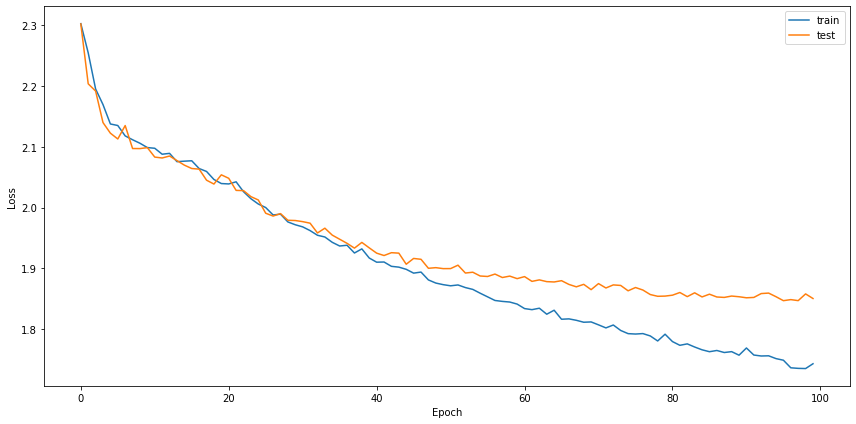

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [22]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Overall accuracy 0.6082
Precision [0.66225839 0.74317492 0.471843   0.47052023 0.49956934 0.49369369
 0.73556582 0.62068966 0.8015873  0.68562565]
Recall [0.651 0.735 0.553 0.407 0.58  0.548 0.637 0.702 0.606 0.663]
Mean Precision 0.6184528004890482
Mean Recall 0.6082000000000001
